# Multiple Results Analysis

This notebook is intended to read a simulation results file with multiple simulations and results and create aggregate analyses and visualizations.

In [31]:
%matplotlib inline

import os
import sys 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

In [32]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [33]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures")
# RESULTS  = os.path.join(FIXTURES, "experiments", 'eventually-there-multi-20160219.json')
# RESULTS  = os.path.join(FIXTURES, "experiments", 'raft-quorum-multi-20160219.json')
# RESULTS  = os.path.join(FIXTURES, "experiments", 'anti-entropy-multi-20160223.json')
# RESULTS  = os.path.join(FIXTURES, "experiments", 'raft-quorum-commit-20160307.json')
RESULTS  = os.path.join(FIXTURES, "experiments", 'single-cluster-20160307.json')
# RESULTS  = os.path.join(FIXTURES, 'test-raft-multi.json')

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        return json.load(f)

# Load the data
data = get_results_data()

# Get all the values for a particular key 
def results_values(*key):
    for result in data:
        value = result
        for k in key:
            value = value.get(k, {})
        yield value

rvals = results_values

In [34]:
# Print report details 
def report_settings(exclude=None):
    table = defaultdict(dict)
    exclude = exclude or frozenset([
        'valid_locations', 'invalid_types', 
        'default_replica', 'default_consistency', 'default_latency', 
        'max_sim_time', 'title', 'description',
        'election_timeout', 'heartbeat_interval',
    ])
    
    for idx, conf in enumerate(rvals('settings')):
        eid = "e{:0>2}".format(idx)
        table[eid]['name'] = eid
        for key, val in conf.iteritems():
            if key in exclude: continue
            table[eid][key] = val
    
    for idx, conf in enumerate(rvals('topology', 'meta')):
        eid = "e{:0>2}".format(idx)
        for key, val in conf.iteritems():
            if key in exclude: continue
            table[eid][key] = val

    return pd.DataFrame(table.values())

print report_settings()

    access_mean  access_stddev  anti_entropy_delay constant do_gossip  \
0          1800            512                 600   2380ms      True   
1          1800            512                 600   2130ms      True   
2          1800            512                 600   2630ms      True   
3          1800            512                 600   1380ms      True   
4          1800            512                 600   1630ms      True   
5          1800            512                 600    630ms      True   
6          1800            512                 600   1880ms      True   
7          1800            512                 600   1630ms      True   
8          1800            512                 600   2880ms      True   
9          1800            512                 600   2630ms      True   
10         1800            512                 600   2380ms      True   
11         1800            512                 600   2130ms      True   
12         1800            512                 600 

In [35]:
def create_dataframe():
    table = []
    meta  = list(rvals('topology', 'meta'))
    conf  = list(rvals('settings'))

    for idx, results in enumerate(rvals('results')):
        data = {'eid': "e{:0>2}".format(idx)}
        data['variable (ms)'] = meta[idx]['variable']
        
        # Variable latency 
        latency = meta[idx]['variable'].rstrip('ms').strip().split('-')
        latency = sum(map(float, [ms for ms in latency if ms != 'N/A'])) / 2
        
        # Constant latency 
        if not latency:
            latency = float(meta[idx]['constant'].rstrip('ms').strip())
        
        data['mean latency (ms)'] = latency
        data['constant (ms)'] = meta[idx]['constant']
        data['users'] = conf[idx]['users']
        data['anti-entropy delay (ms)'] = conf[idx]['anti_entropy_delay']
        for key, values in results.iteritems():
            if key == 'visibility latency':
                data['visibility latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
                data['visible writes'] = len(set([v[1] for v in values]))
            if key == 'commit latency':
                data['commit latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
                data['committed writes'] = len(set([v[1] for v in values]))
            else:
                data[key] = len(values)
        
        data['ratio fully visible to writes'] = float(data['visible writes']) / float(data['write'])
        
        table.append(data)
    
    return pd.DataFrame(table)

df = create_dataframe()

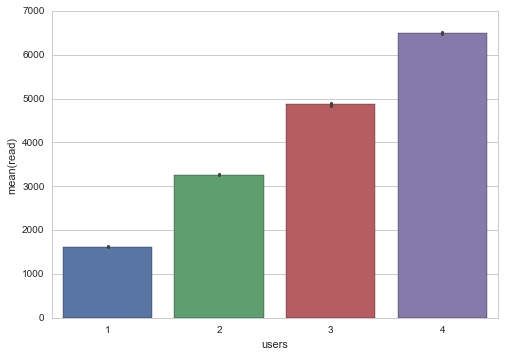

In [36]:
ax = sns.barplot(x='users', y='read', data=df)

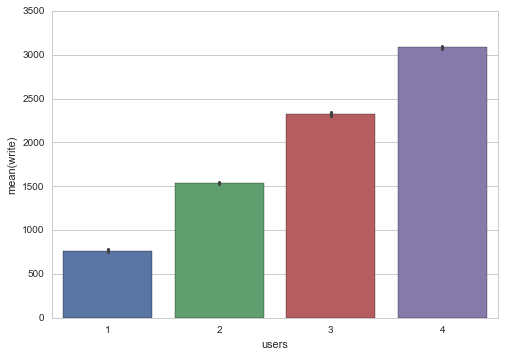

In [37]:
ax = sns.barplot(x='users', y="write", data=df)

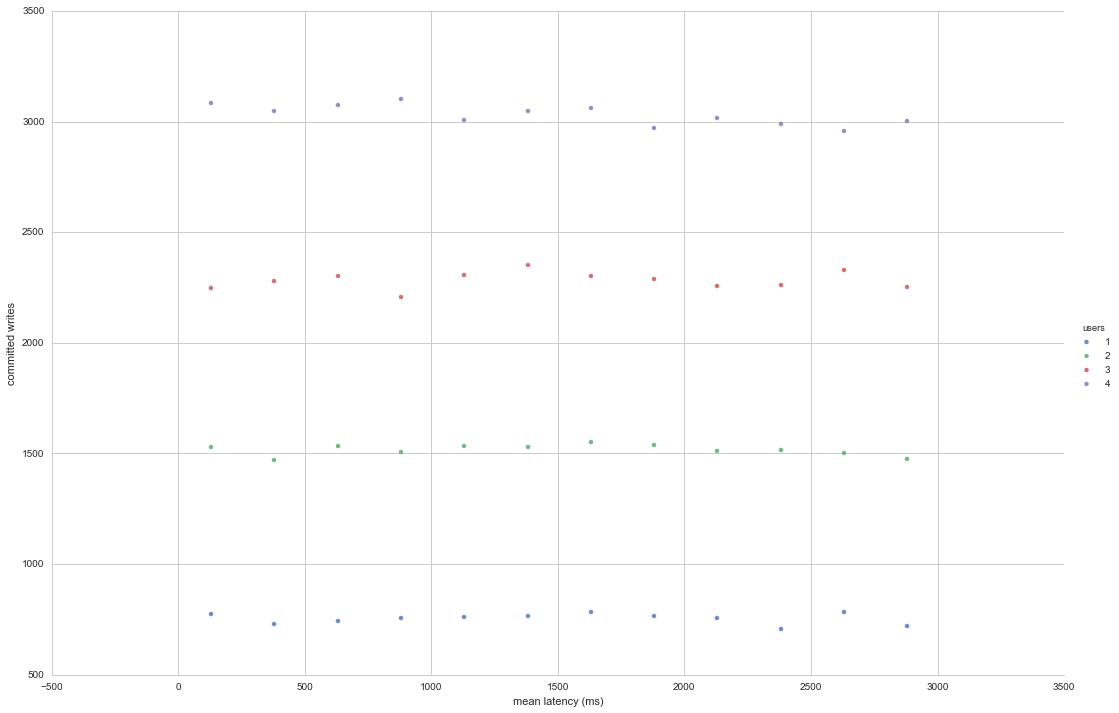

In [38]:
ax = sns.lmplot(
    x="mean latency (ms)", y="committed writes", hue='users', 
    data=df, fit_reg=False, size=10, aspect=1.5
)

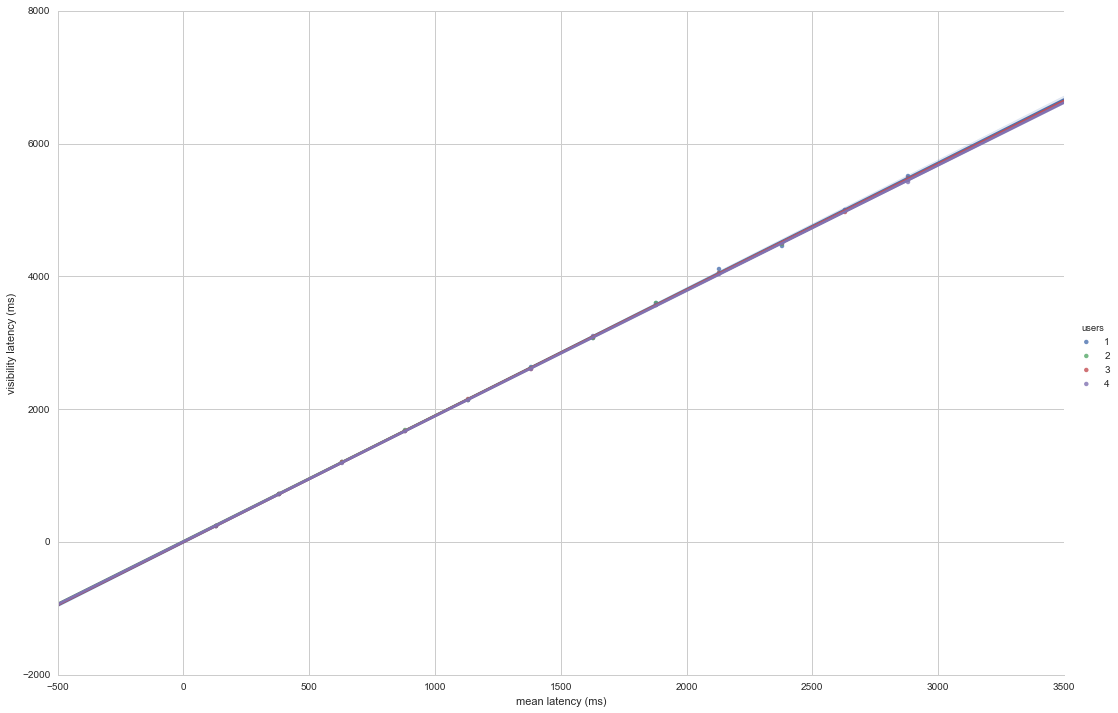

In [39]:
ax = sns.lmplot(
    x="mean latency (ms)", y="visibility latency (ms)", hue='users', 
    data=df, fit_reg=True, size=10, aspect=1.5
)

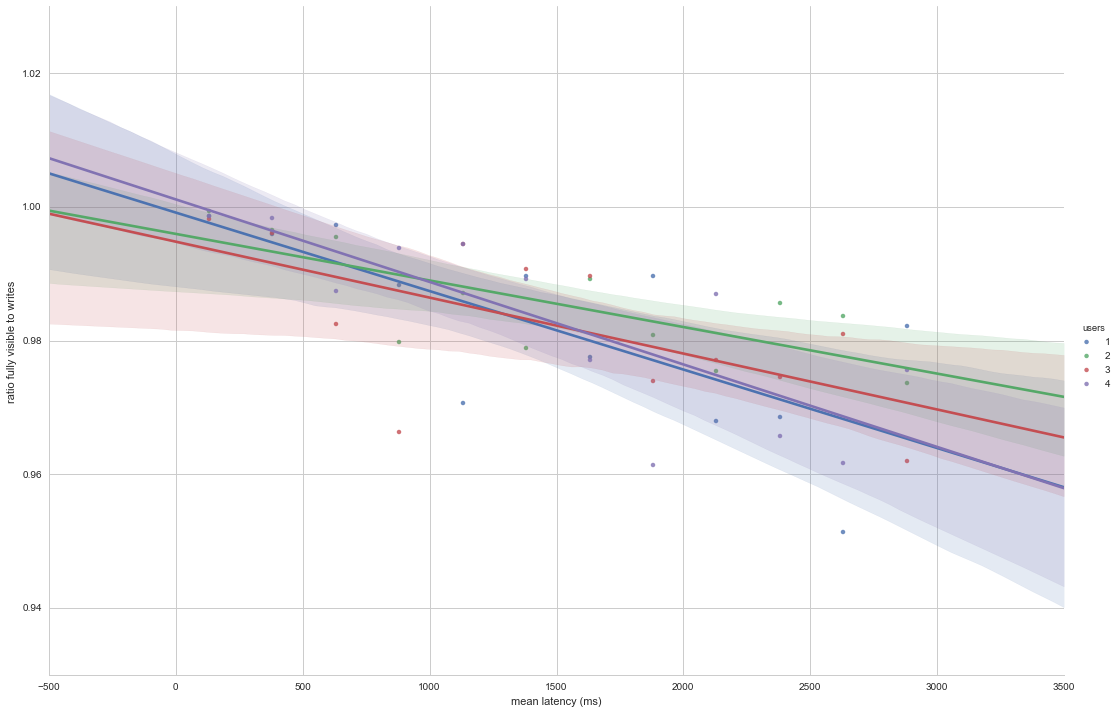

In [40]:
ax = sns.lmplot(
    x="mean latency (ms)", y="ratio fully visible to writes", hue='users', 
    data=df, fit_reg=True, size=10, aspect=1.5
)

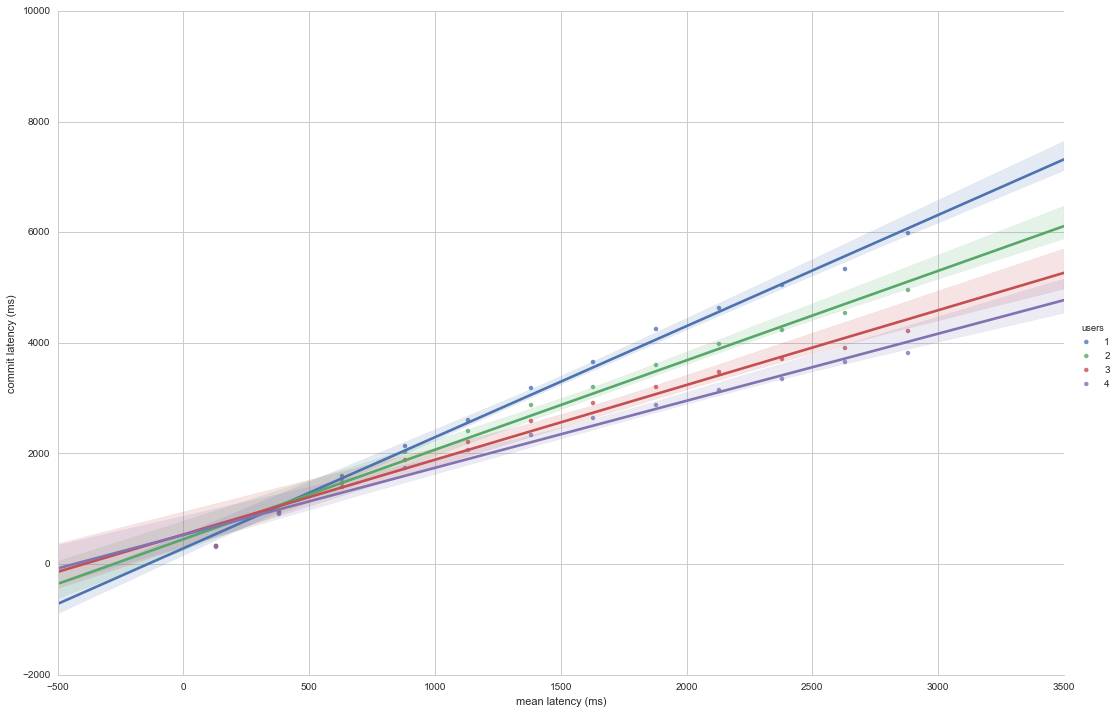

In [41]:
ax = sns.lmplot(
    x="mean latency (ms)", y="commit latency (ms)", hue='users', 
    data=df, fit_reg=True, size=10, aspect=1.5
)